# Project notebook **<span style="COLOR:RED">(complete this cell)</span>**


### Student 1 (first half presentation)
Name : Sebastien Moeller
<br>Group : advanced
### Student 2 (second half presentation)
Name : Viktor Malesevic
<br>Group : advanced
### Data name : 

Bitcoin price evolution vs Google Trends

### Data URL : 

API from
https://poloniex.com/exchange
and
https://trends.google.fr/trends/


### Short summary of the project and datasource :
<span style="COLOR:RED">Linking google research trends to the prices of cryptocurrencies.</span>

# General instructions (this cell might be deleted for submission)
** <span style="color:red"> Write all the project in this file : code and explanations and upload it before January 7th at 23:55 </span> ** : 

<span style="color:red">Remember : Code cells must be smaller than 30 lines </span>

Every thing must be in the notebook :

* Explanation of what you want to do with data should be present in the Notebook
* Download data in the notebook (check the URL availability) and give the source of data (both URL and textual description)
* Give as much as possible characteristics of data (size, type, fields, ...)
* Provide visualisation of the data that you think useful
* Check for the consistence of the dataset (error, missing data,...) and correct and/or delete errors
* **Ask yourself a question that request you to perform an estimation** (for example, you can choose a data depending on time, and try to predict the latest 10% of data knowing the rest of data). **This will typically be solved through the proposal of a model and fitting the parameters of the model to (part of) the data.**

If you end up writing long chunks of code, make sure you split it in logical «smaller code cells» and explain the logic. The Juptyer Notebook will be **both the memoire** you will submit for evaluation **and the visual support** for your oral presentation of your project, keep this in mind while writing it.

### Aims : 
** <span style="color:red"> Here explain what you want to do with data</span> ** 
* The idea of the project is to see how google research trends influence cryptocurrencies prices
* So we want to combine historical prices to historical google trends research related to cryptocurrencies

* Then the major idea is to be able to give investment recommandations according to these trends. What will be future price according to trends. And will the price increase or decrease? To which extend?

### Download : 
** <span style="color:red">Write explanations here</span> ** 
* 
* 
* 

Importing Cryptocurrency

** <span style="color:red">If there is any obvious data curation to be performed upon initial data loading, do it here</span> ** 



In [36]:
### write code here (use as many cells as needed)


### Data charaterisctics :  Here, give as much as possible characteristics of data
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [37]:
### write code here (use as many cells as needed)


NameError: name 'plot' is not defined

### Data visualisation and representation
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [ ]:
### write code here (use as many cells as needed)



### Data consistency checking
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [ ]:
### write code here (use as many cells as needed)



### Estimation question
** <span style="color:red"> Write explanations here</span> ** 
* So here as we said before we want to see how we can predict the closing price of a day according to google trends.

* Let's start with a simple fitting method:

In [1]:
### We first import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [2]:
###
data = pd.read_csv("C:\\Users\\DataScience\\Desktop\\Python Course\\MAP536_Python_Final-master\\data.csv")

In [3]:
### We delete the unnecessary column and transform the data as a new index for our dataframe
del data['Unnamed: 0']

data.set_index('date', inplace = True)

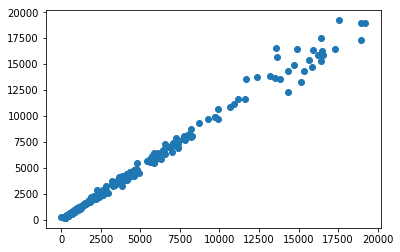

In [34]:
plt.scatter(data["open"],data["close"])
plt.show()

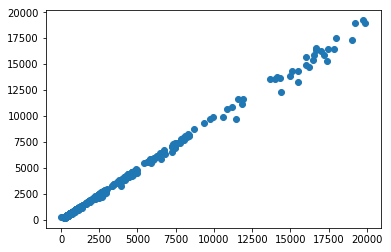

In [35]:
plt.scatter(data["high"],data["close"])
plt.show()

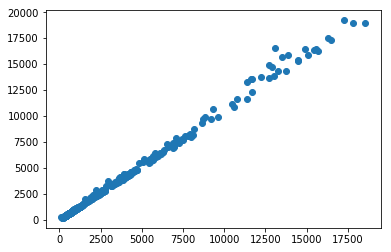

In [36]:
plt.scatter(data["low"],data["close"])
plt.show()

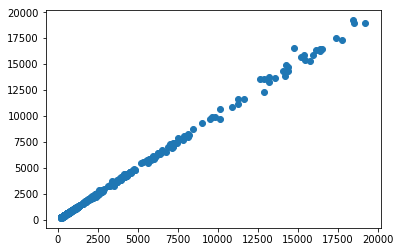

In [37]:
plt.scatter(data["weightedAverage"],data["close"])
plt.show()

### Remark:

Up to here we have very correlated data. One might think that this is amazing and it will be very easy to predict closing price! But this correlation is actually normal: for example close price is defined as open pric the day before. And most of these variables are directly calculated from each other. So that does not give much "interesting" information. A part maybe from the fact that price in general does not move a lot from one day to another (if compared to the whole price evolution).

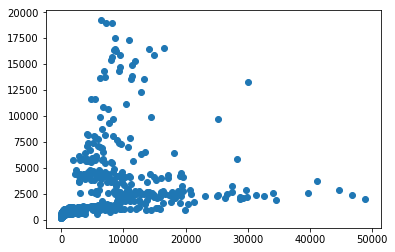

In [38]:
plt.scatter(data["quoteVolume"],data["close"])
plt.show()

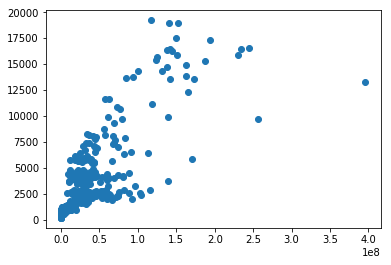

In [39]:
plt.scatter(data["volume"],data["close"])
plt.show()

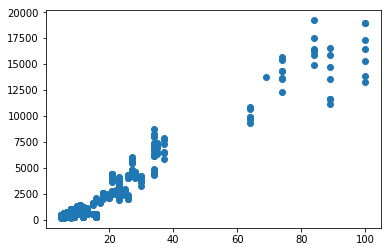

In [40]:
plt.scatter(data["tBTC"],data["close"])
plt.show()

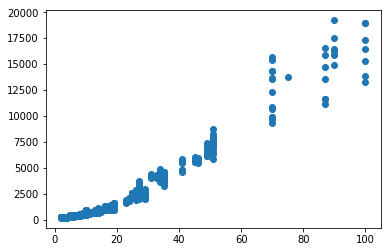

In [41]:
plt.scatter(data["tBlockchain"],data["close"])
plt.show()

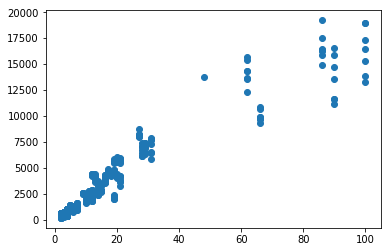

In [42]:
plt.scatter(data["tBitCoin"],data["close"])
plt.show()

#### Here we see that the graph of close price vs tBlockchain seem to look like a polynomial function. Degree 3?

Let's try to make our data "fit" a polynomial function and see which function estimates our price with the least errors.
For that we will define polynomial functions and find the parameters minimizing the least square errors thanks to scipy.optimize.

In [20]:
## Let's first try with a degree 3 polynomial function.

## Let's define these functions:

def polynomial_model(param, x): ### Polynome of degree 3
    return param[0] + param[1]*x + param[2]*x**2 + param[3]*x**3

def polynomial_err(param, x, y):
    return y - polynomial_model(param, x)

In [21]:
## Here we generate the minimization algorithm. Param1 is the set of coefficients of the polynomial function minimizing the least square error

x_data = data['close']
y_data = data['tBlockchain']    

param0 = [1, 1, 1, 1] ## Initialisation of the iterations

param1, meta_res = scipy.optimize.leastsq(polynomial_err, param0[:], args = (x_data, y_data))

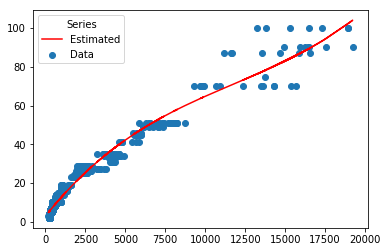

Initial parameters : [1, 1, 1, 1]
Estimated parameters : [  2.92074652e+00   1.03641347e-02  -5.82906120e-07   1.65135730e-11]
1


In [22]:
## Now let's plot our result

y_model = polynomial_model(param1, x_data) 
plt.scatter(x_data,y_data,label='Data')
plt.plot(x_data,y_model,label='Estimated', color = 'Red')
plt.legend(loc='best', title='Series')
plt.show()

print("Initial parameters :", param0)
print("Estimated parameters :", param1)

print(meta_res)

We see that the estimation curve is "thick" due to unordered data. This issue can be solved with the following method:

In [23]:
data = data.sort_values('tBlockchain', ascending=True)

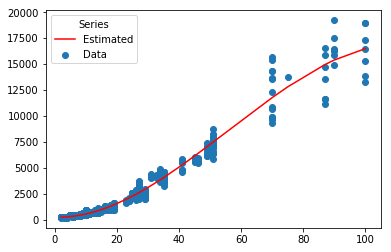

Initial parameters : [1, 1, 1, 1]
Estimated parameters : [  2.62381472e+02  -1.07468899e+01   4.30477307e+00  -2.57471800e-02]
1


In [24]:
## Relaunch the code with ordered data

def polynomial_model(param, x):
    return param[0] + param[1]*x + param[2]*x**2 + param[3]*x**3

def polynomial_err(param, x, y):
    return y - polynomial_model(param, x)

#%%
x_data = data['tBlockchain'] 
y_data = data['close']   

param0 = [1, 1, 1, 1] ## Initialisation of the iterations

param1, meta_res = scipy.optimize.leastsq(polynomial_err, param0[:], args = (x_data, y_data))
#%%
y_model = polynomial_model(param1, x_data) 
plt.scatter(x_data,y_data,label='Data')
plt.plot(x_data,y_model,label='Estimated', color = 'Red')
plt.legend(loc='best', title='Series')
plt.show()

print("Initial parameters :", param0)
print("Estimated parameters :", param1)

print(meta_res)

#### Now: how to make sure that this polynome is the one that is the best predictor? What about degree 2? What about degree 4?

Let's compare how good are different polynomes at predicting the closing price.
For that we cannot measure the performance of each polynome by seeing how well they fit the training data: obviously, the higher the degree, the best "fit" (-> overfitting)

So, in order to measure the performances of each polynome we will split the data into training and testing sets, and see how well each polynome fits the testing set (the part of the data not used to build the model).

#### To do so, we need to shuffle the data and separate the set in 70%/30% for example.

### Cross Validation

In [25]:
data.reset_index(inplace = True)

# 70% training and 30% testing
def shuff(data, ratio = 0.3):    
    N = len(data)

    randomized_indices = np.arange(N)
    np.random.shuffle(randomized_indices)
 
    #dataset after index randomization
    shuffled_data = data.iloc[randomized_indices,:] 

    ### Split the dataset into two subsets ###

    ## Build training set ##
    training_data = shuffled_data[:int((1-ratio)*N)]

    ## Build testing set ##
    testing_data = shuffled_data[int((1-ratio)*N):]
    
    return training_data, testing_data

In [26]:
#%%
training_data, testing_data = shuff(data)

training_data = training_data.sort_values('tBlockchain', ascending=True)    
testing_data = testing_data.sort_values('tBlockchain', ascending=True)  

x_data = training_data['tBlockchain'] 
y_data = training_data['close']   

x_test = testing_data['tBlockchain'] 
y_test = testing_data['close']

#### Let's now define the functions we will use to create different polynomes, optimize them, and measure their performances:

In [27]:
def meanSquareError(true, predicted): ### This function gives the mean square error
    delta = true - predicted
    return sum(delta**2)/len(delta)

def polynomialModelN(n, param, x): ### This function creates a polynome of degree n
    temp = 0
    for i in range(n):
        temp = temp + param[i]*x**(i)
    return temp

def polynomialError(param, x, y): ### This function is defining the error between observed values and fitted values
    return y - polynomialModelN(len(param), param, x)

In [32]:
### Here we create the function that plots and compares N polynomes in increasing degree order:

def magic(n, x_data = x_data, x_test = x_test, y_data = y_data, y_test = y_test):
    n = n+1
    param0 = np.ones(n)
    param1, meta_res = scipy.optimize.leastsq(polynomialError, param0[:], args = (x_data, y_data))
    
    plt.scatter(x_data,y_data,label='Training Data', color = '#EBA911')
    plt.scatter(x_test,y_test,label='Testing Data', color = '#0CC88F' )
    
    smooth_x = np.linspace(0,max(x_data),1000)   #### This is to make sure that our curve is "smooth"
    
    plt.plot(smooth_x,polynomialModelN(n, param1, smooth_x),label='Estimated', color = 'Red')
    plt.legend(loc='best', title='Series')
    plt.show()
    
    mseTrain = meanSquareError(y_data, polynomialModelN(n, param1, x_data))
    mseTest = meanSquareError(y_test, polynomialModelN(n, param1, x_test))
    
    return int(mseTrain), int(mseTest)

def trainTestError(n):
    error = []
    for i in range(n):
        error.append(magic(i+1))
    
    plt.plot(error)
    plt.xticks(list(range(0,n)),list(range(1,n+1)))
    plt.show()
    
    return error

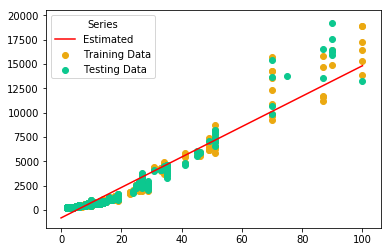

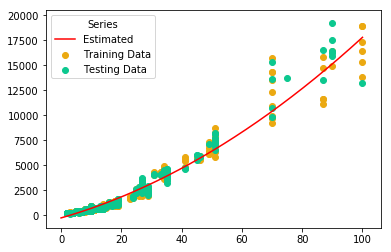

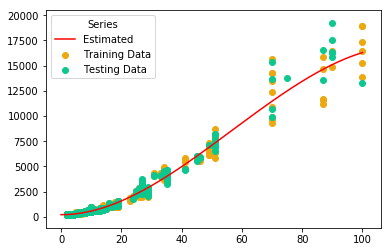

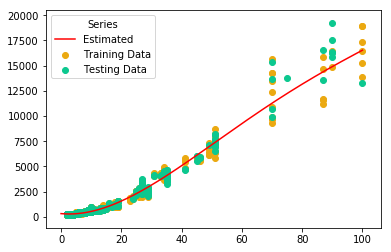

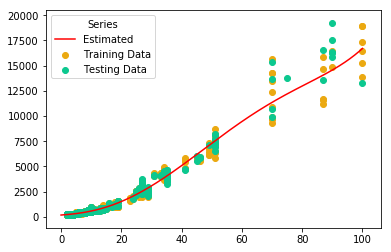

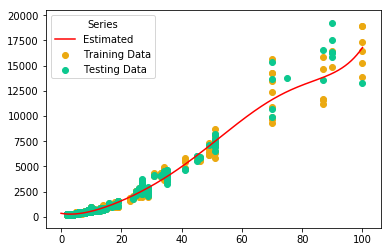

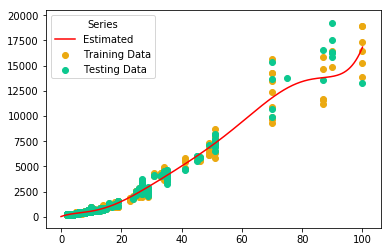

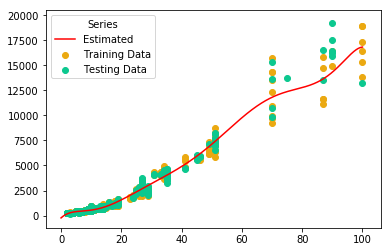

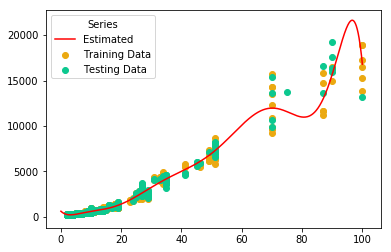

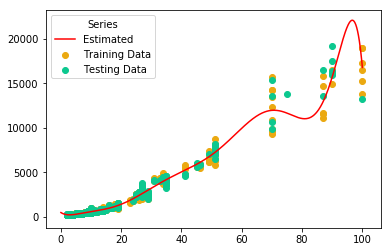

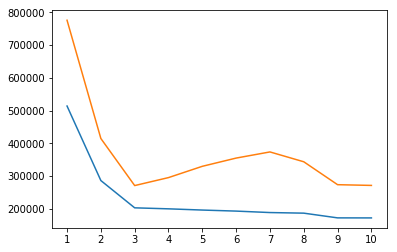

[(513867, 775923),
 (286203, 414641),
 (202867, 270877),
 (199814, 295243),
 (196081, 329713),
 (192892, 354865),
 (188453, 373629),
 (186600, 343575),
 (172193, 273569),
 (172064, 271350)]

In [33]:
trainTestError(10)

#### What do we see here?

Most of the time, the polynome showing the lower error on the testing data set is of degree 3 (see orange curve). However this seem to depend quite a lot on the shuffle operation before splitting the set. An interesting idea would thus be to run a several simulations and take the average degree of the polynome best fitting the testing data.

We did not do it here unfortunately because we wanted to try different prediction methods instead, but this would be an interesting thing to develop.

### Another import remark:

Here we see that google research trends "jump" from a value to another, without being very "continuous". This is due to the fact that unfortunately we only have weekly data for Google Trends...

By having daily data we might have much more precise results. Indeed if we looks at the 2nd and 3rd week of December 2017, Bitcoin prices have increased and decreased a lot within the same week. Which ends up in high variability for closing price for a same "trend score". Making our model less predictable.

### As many other optional questions as you want
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 